**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [2]:
import numpy as np
import time
import pandas as pd
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

### Histogram of Oriented Gradients (HOG)


In [3]:
# Divide up into cars and notcars
images = glob.glob('./non-vehicles/**/*.png', recursive=True)
notcars = []
for image in images:
    notcars.append(image)

images = glob.glob('./vehicles/**/*.png', recursive=True)
vehicle_files = images

cars = []
for image in images:
    cars.append(image)

In [4]:
# vehicle_files = glob.glob('./vehicles/**/*.png')
vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in cars]
# non_vehicle_files = glob.glob('./non-vehicles/**/*.png')
non_vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in notcars]
num_vehicles, num_non_vehicles = len(vehicle_imgs), len(non_vehicle_imgs)
all_imgs = vehicle_imgs + non_vehicle_imgs

In [5]:
print ("Vehicle Files: %r"%len(vehicle_files))
print ("Non-Vehicle Files: %r"%len(vehicle_files))

Vehicle Files: 8792
Non-Vehicle Files: 8792


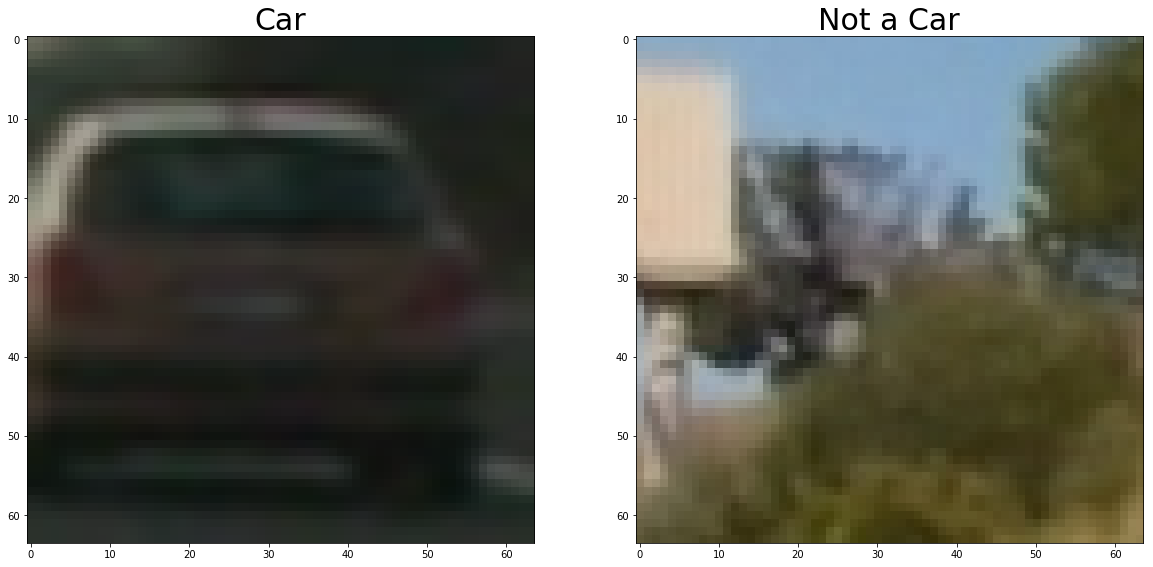

In [6]:
def car_not_car(img1, img2, title1, title2):
    cmap = None if len(img1.shape) == 3 else 'gray'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)
    plt.savefig('./figures/'+title1+'_'+title2+'.jpg', bbox_inches='tight')

ind1, ind2 = np.random.randint(0, len(vehicle_imgs), 2)
car_not_car(vehicle_imgs[ind1], non_vehicle_imgs[ind2], 'Car', 'Not a Car')


In [7]:
def bin_spatial(img, color_space='RGB', size=(16, 16)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size)
#     features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

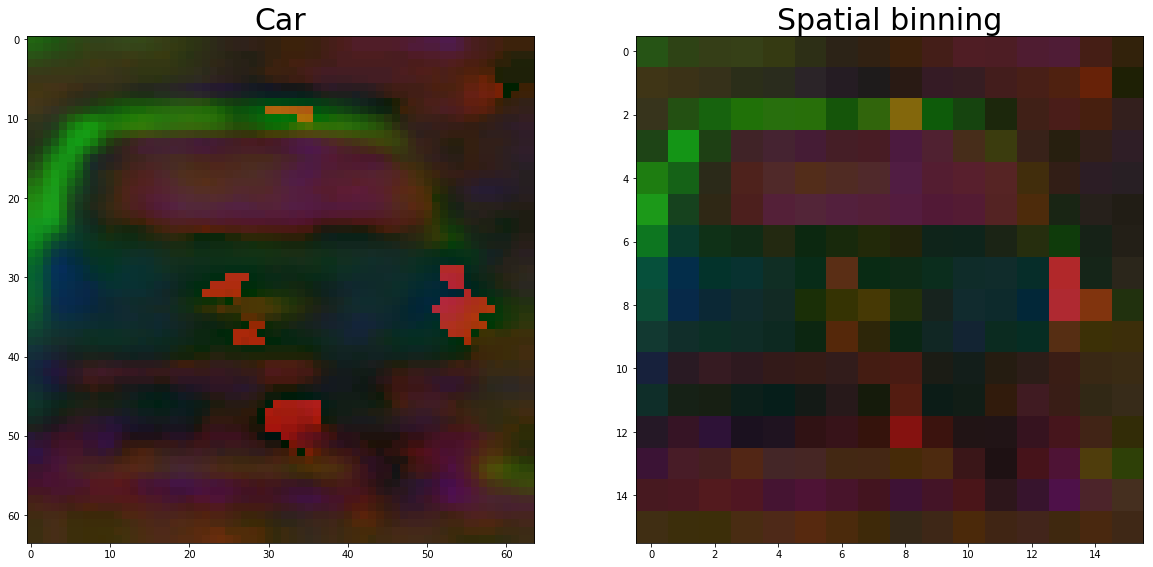

In [8]:
vehicle_img_copy = vehicle_imgs.copy()
vehicle_img = cv2.cvtColor(vehicle_imgs[ind1], cv2.COLOR_RGB2HLS)
bin_spatial_feats = bin_spatial(vehicle_img)
car_not_car(vehicle_img, bin_spatial_feats, 'Car', 'Spatial binning')

In [9]:
# Define a function to return HOG features and visualization
# get_hog_features = get_hog
def get_hog(img, orient = 9, pix_per_cell = (8,8), cell_per_block = (2,2), vis=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=pix_per_cell,
                                  cells_per_block=cell_per_block, transform_sqrt=False, 
                                  visualise=True, feature_vector=True)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=pix_per_cell,
                       cells_per_block=cell_per_block, transform_sqrt=False, 
                       visualise=False, feature_vector=True)
        return features

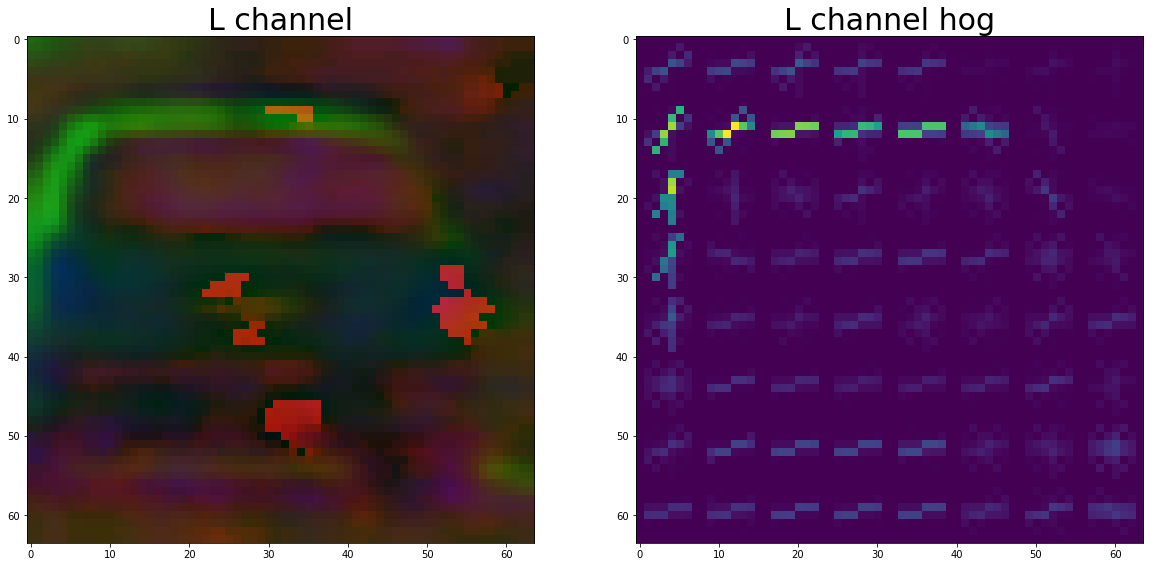

In [10]:
vehicle_img_l = vehicle_img[:,:,1]
hog_feats, hog_img = get_hog(vehicle_img_l, vis=True)
car_not_car(vehicle_img, hog_img, 'L channel', 'L channel hog')

In [11]:
def get_feature_vector(image):
    image_resized = cv2.resize(image, (64, 64), cv2.INTER_AREA)
    image_hls = cv2.cvtColor(image_resized, cv2.COLOR_RGB2HLS)
    bin_spatial_feats = bin_spatial(image_hls, color_space = 'HLS').ravel()
    hog_features_h = get_hog(image_hls[:,:,0]).ravel()
    hog_features_l = get_hog(image_hls[:,:,1]).ravel()
    hog_features_s = get_hog(image_hls[:,:,2]).ravel()
    img_features = np.concatenate((bin_spatial_feats, hog_features_h, hog_features_l, hog_features_s))
    return img_features

In [12]:
x_list = [get_feature_vector(img) for img in all_imgs]

In [13]:
X = np.vstack(x_list).astype(np.float64)

In [14]:
x = np.vstack(x_list).astype(np.float64)

x_scaler = StandardScaler().fit(x)

# Apply the scaler to X
scaled_X = x_scaler.transform(x)
x = x_scaler.transform(x)
y = np.array([1] * num_vehicles + [0] * num_non_vehicles)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

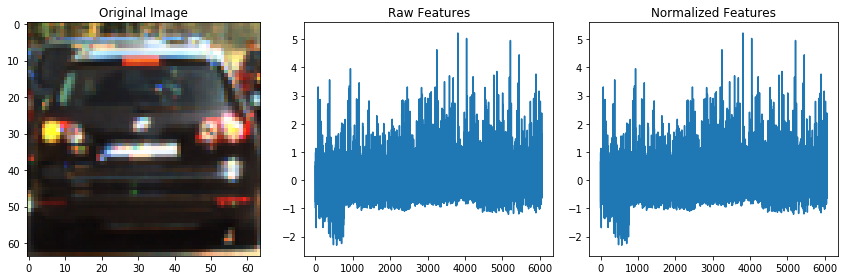

In [15]:
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
# Visualize the distribution of raw and normalized features
# of a sample image.
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(x[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig('./figures/histogram_car_'+str(car_ind)+'.jpg', bbox_inches='tight')

In [85]:
# Use a linear SVC 
clf = LinearSVC(C = .01)
# Check the training time for the SVC
t=time.time()
clf.fit(x_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(clf.score(x_test, y_test))

22.5 Seconds to train SVC...
0.985078828829


In [54]:
# clf = SVC(kernel='rbf', random_state=9)
# t=time.time()
# clf.fit(x_train, y_train) 
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# print(clf.score(x_test, y_test))

289.73 Seconds to train SVC...
0.992117117117


In [106]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [107]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

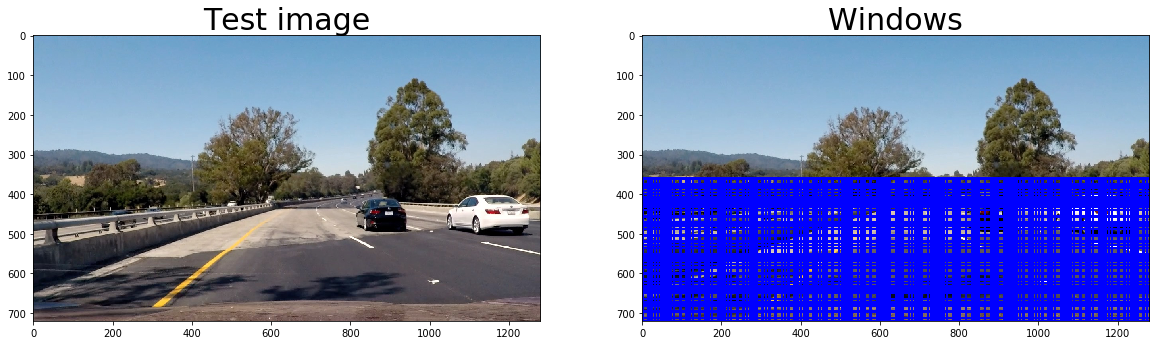

In [57]:
randint = np.random.randint(1,6)
# image = plt.imread('test_images/test'+str(randint)+'.jpg')
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
y_start_stop=[int(image.shape[0]/2), int(image.shape[0])]
window_sizes = [(64, 64), (96, 96), (128, 128), (160, 160), (192, 192), (224, 224)]
# window_sizes = [(64, 64), (96, 96), (128, 128), (160, 160), (192, 192)]
windows = [] 
for window_size in window_sizes:
    new_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=window_size, 
                               xy_overlap=(0.75, 0.75))
    windows.extend(new_windows)

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
car_not_car(image, window_img, 'Test image', 'Windows')

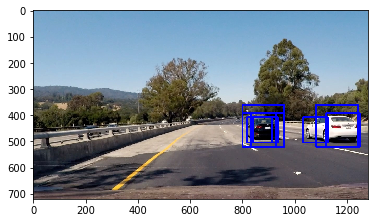

In [64]:
car_windows = []
for window in windows:
    img_section = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    img_section_features = get_feature_vector(img_section)
    img_section_features = x_scaler.transform([img_section_features])[0]
    pred = clf.predict([img_section_features])[0]
    # New Code
    conf = clf.decision_function(img_section_features)            
    if pred == 1 and conf > .3: 
#     if pred == 1:
        car_windows.append(window)
image_vehicles = draw_boxes(image, car_windows, color=(0, 0, 255), thick=6)
plt.imshow(image_vehicles)
plt.savefig('./figures/sliding_window.jpg', bbox_inches='tight')

In [108]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def get_labeled_bboxes(img, labels):
    bboxes = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if( abs(bbox[0][0]-bbox[1][0])> 50 and abs(bbox[0][1]-bbox[1][1])> 50) : # too small rect
            bboxes.append(bbox)
    return bboxes

def get_heatmap_windows(image, windows, threshold=2):
# def get_heatmap_windows(image, windows, threshold=1):    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    heatmap_windows = get_labeled_bboxes(image, labels)
    return heatmap, heatmap_windows

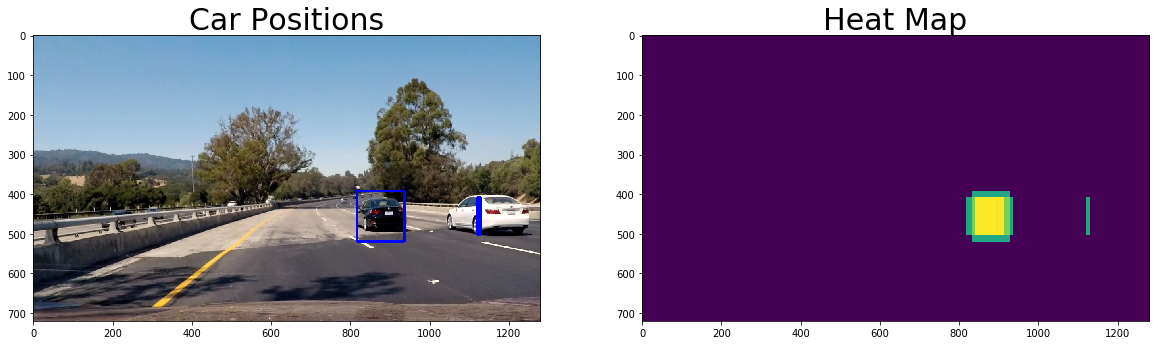

In [66]:
heatmap, heatmap_boxes = get_heatmap_windows(image, car_windows, 2)
draw_img = draw_boxes(np.copy(image), heatmap_boxes, color=(0, 0, 255), thick=6)

car_not_car(draw_img, heatmap, 'Car Positions', 'Heat Map')

In [75]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


In [114]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def detect_cars(img, ystart, ystop, scale, clf, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, confidence = .60):
    vehicle_windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = hog(ch1, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=False, feature_vector=False)
    hog2 = hog(ch2, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=False, feature_vector=False)
    hog3 = hog(ch3, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=False, feature_vector=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            spatial_features = bin_spatial(subimg, color_space = 'HLS').ravel()

            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            # New Code
            conf = clf.decision_function(test_features)            
            if test_prediction == 1 and conf > confidence:  
                
#             if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                vehicle_window = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                vehicle_windows.append(vehicle_window)
    return vehicle_windows


In [119]:
last_windows = []
def process_image(image):
    global last_windows
    #maybe change this
    frames_to_keep = 5
    y_start=int(image.shape[0]/2)
    y_stop=int(image.shape[0])
#     scales = [1, 1.5, 2, 2.5, 3, 3.5]
#     scales = [1.2, 1.8, 2.4]
    scales = [1.2, 1.8]
    car_windows = []
    for scale in scales:    
        car_windows.extend(detect_cars(image, y_start, y_stop, scale, clf, x_scaler, confidence=.3))
    _, new_windows = get_heatmap_windows(image, car_windows, threshold=2)
    if len(last_windows) == frames_to_keep:
        del last_windows[0]
    last_windows.append(new_windows)    
    flattened_windows = [item for sublist in last_windows for item in sublist]
    _, windows_to_draw = get_heatmap_windows(image, flattened_windows, threshold=frames_to_keep-3)
#     _, windows_to_draw = get_heatmap_windows(image, flattened_windows, threshold=frames_to_keep-3)
    draw_img = draw_boxes(np.copy(image), windows_to_draw, color=(0, 0, 255), thick=6)
    return draw_img

In [125]:
output = 'project_video_processed.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_processed2.mp4
[MoviePy] Writing video project_video_processed2.mp4



100%|█████████▉| 1260/1261 [18:21<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed2.mp4 

CPU times: user 16min 45s, sys: 1min 8s, total: 17min 54s
Wall time: 18min 22s


In [123]:
# output = 'project_video_processed_test.mp4'
# # clip = VideoFileClip('project_video.mp4')
# # process a 5 second clip from the 25-30 second mark
# # clip = VideoFileClip("project_video.mp4").subclip(10, 17)
# clip = VideoFileClip("project_video.mp4").subclip(35, 45)
# output_clip = clip.fl_image(process_image)
# %time output_clip.write_videofile(output, audio=False)